In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from model import *

# prepare data

In [3]:
train = pd.read_csv("../train_valid.csv", header=None)

In [5]:
labels = train.iloc[:, 784]

In [150]:
class_dist = labels.value_counts()
class_dist = class_dist.reset_index()
class_dist.columns = ["class", "cnt"]
class_dist = class_dist.sort_values(["class"])

/Library/anaconda3/envs/pytorch1.10/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  after removing the cwd from sys.path.


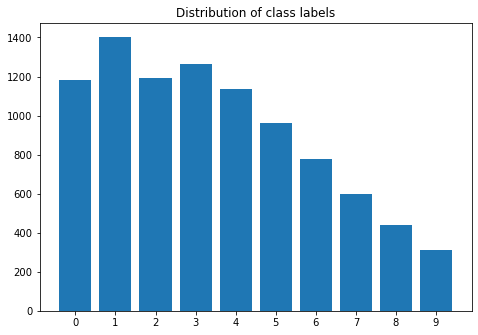

In [158]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(class_dist["class"], class_dist["cnt"])
ax.set_xticks(np.arange(10), [0,1,2,3,4,5,6,7,8,9])
ax.set_title('Distribution of class labels')
plt.xticks(np.arange(10))
plt.show()

In [6]:
image_arr = train[train.columns[:784]].to_numpy()
image_arr = image_arr.reshape(9269, 28, 28)

In [59]:
X_train = torch.unsqueeze(torch.from_numpy(image_arr), dim=1)
y_train = torch.from_numpy(labels.to_numpy()).long()

train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_data_loader = DataLoader(train_data, batch_size=64, num_workers=1, shuffle=True, drop_last=True)

- use for test data

In [99]:
X_test = torch.unsqueeze(torch.from_numpy(image_arr), dim=1)
y_test = torch.from_numpy(labels.to_numpy()).long()

test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_data_loader = DataLoader(train_data, batch_size=64, num_workers=1, shuffle=False, drop_last=False)

### Train model

In [61]:
def calculat_acc(output, target):
    num_class = 10
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    correct = torch.sum(output == target).item()
    return correct

In [ ]:
net = get_model("cnn")
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [137]:
net

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
 

In [126]:
for epoch in range(20):
    running_loss = 0.0
    net.train()
    batch = 0
    correct, cnt = 0, 0
    for data in train_data_loader:
        imgs, label = data
        optimizer.zero_grad()
        output = net(imgs.float())
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        
        cnt += imgs.shape[0]
        correct += calculat_acc(output, label)
        
    print("epoch %d, loss: %.4f, accuracy: %.4f" % (epoch, running_loss, correct / cnt))

epoch 0, loss: 269.7647, accuracy: 0.3455
epoch 1, loss: 173.1156, accuracy: 0.5858
epoch 2, loss: 141.5431, accuracy: 0.6669
epoch 3, loss: 119.1677, accuracy: 0.7206
epoch 4, loss: 104.1293, accuracy: 0.7576
epoch 5, loss: 93.2038, accuracy: 0.7824
epoch 6, loss: 83.3027, accuracy: 0.8057
epoch 7, loss: 73.3114, accuracy: 0.8305
epoch 8, loss: 67.7107, accuracy: 0.8402
epoch 9, loss: 63.6537, accuracy: 0.8474
epoch 10, loss: 55.8814, accuracy: 0.8677
epoch 11, loss: 50.5484, accuracy: 0.8809
epoch 12, loss: 46.4329, accuracy: 0.8887
epoch 13, loss: 43.8228, accuracy: 0.8955
epoch 14, loss: 41.2808, accuracy: 0.9006
epoch 15, loss: 37.1724, accuracy: 0.9099
epoch 16, loss: 34.6620, accuracy: 0.9169
epoch 17, loss: 31.3079, accuracy: 0.9274
epoch 18, loss: 28.8177, accuracy: 0.9319
epoch 19, loss: 27.7423, accuracy: 0.9327


In [127]:
torch.save({'model_state_dict': net.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(),}, 
           "model.pth")

## Predict

In [128]:
def predict(model, data_loader):
    model.eval()
    
    y_pred = None
    for data in data_loader:
        imgs, label = data
        optimizer.zero_grad()
        output = model(imgs.float())
        output = nn.functional.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        if y_pred is None:
            y_pred = output
        else:
            y_pred = torch.cat([y_pred, output], dim=0)
            
    return y_pred

In [129]:
checkpoint = torch.load("model.pth")
net.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [130]:
y_pred = predict(net, test_data_loader)
y_pred = pd.DataFrame(y_pred.detach().numpy())
y_pred.to_csv("Q3 predicted results.csv", index=False, header=False)
print("Predict accuracy: %.4f" % (sum(labels == y_pred[0]) / len(labels)))

Predict accuracy: 0.9705


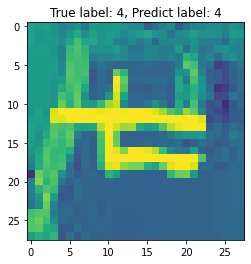

In [136]:
i = 5999
plt.imshow(image_arr[i], vmin=0, vmax=1)
plt.title("True label: %d, Predict label: %d" % (labels.iloc[i], y_pred.iloc[i]))
plt.show()